# Italian Financial Challenge - Starter Template

**Student Name:** [Your Name]

**Challenge:** [Choose: Bankruptcy Prediction / Financial Health Classification / Revenue Forecasting]

**Date:** [Date]

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** [Describe which challenge you chose and why]

**Objective:** [State the prediction goal clearly]

**Success Criteria:** [Define what "good" performance looks like for your chosen challenge]

**Approach:** [Briefly outline your planned approach]

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Create images folder for saved plots
IMAGES_DIR = Path('../images')
IMAGES_DIR.mkdir(exist_ok=True)

def save_fig(name, dpi=150):
    path = IMAGES_DIR / f"{name}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")



Libraries imported successfully!


## 2. Data Loading and Exploration (Refactored EDA: Lean, Defensible, Leakage-Safe)

This section prioritizes a minimal, high-signal set of plots (8–10) with scale-aware visuals.


### 1. Dataset Overview


In [25]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')


# Recompute revenue_change from production_value (t vs t-1)
if {'company_id', 'fiscal_year', 'production_value'} <= set(train_df.columns):
    train_df = train_df.sort_values(['company_id', 'fiscal_year']).copy()
    pv_prev = train_df.groupby('company_id')['production_value'].shift(1)
    train_df['revenue_change'] = (train_df['production_value'] - pv_prev) / pv_prev
    print('Recomputed revenue_change from production_value (t vs t-1)')

# Explicit target definition for Challenge 3
target_col = 'revenue_change'
target_definition = "Percent change in production_value vs prior year"
target_units = "percentage (%)"

# Columns that are coded as numeric but represent categories
categorical_like_cols = ['ateco_sector'] if 'ateco_sector' in train_df.columns else []

# Basic dataset info
print(f"Dataset shape (rows, cols): {train_df.shape}")
print(f"Unique companies: {train_df['company_id'].nunique()}")
print(f"Fiscal year range: {train_df['fiscal_year'].min()} - {train_df['fiscal_year'].max()}")
print(f"Target: {target_col} ({target_units}) - {target_definition}")

# Feature type breakdown
id_cols = ['company_id']
time_cols = ['fiscal_year']
leakage_targets = ['bankruptcy_next_year', 'financial_health_class']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [
    c for c in numeric_cols
    if c not in id_cols + time_cols + [target_col] + leakage_targets + categorical_like_cols
]

categorical_features = [c for c in categorical_cols if c not in id_cols + leakage_targets]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("\nFeature type counts:")
print(f"Identifiers: {id_cols}")
print(f"Time columns: {time_cols}")
print(f"Target column: {target_col}")
print(f"Other target cols to exclude: {leakage_targets}")
print(f"Numeric feature cols: {len(numeric_features)}")
print(f"Categorical feature cols: {len(categorical_features)}")
print(f"Total usable feature cols: {len(numeric_features) + len(categorical_features)}")


Recomputed revenue_change from production_value (t vs t-1)
Dataset shape (rows, cols): (11828, 30)
Unique companies: 2999
Fiscal year range: 2018 - 2021
Target: revenue_change (percentage (%)) - Percent change in production_value vs prior year

Feature type counts:
Identifiers: ['company_id']
Time columns: ['fiscal_year']
Target column: revenue_change
Other target cols to exclude: ['bankruptcy_next_year', 'financial_health_class']
Numeric feature cols: 21
Categorical feature cols: 4
Total usable feature cols: 25


**What this shows:** dataset scale, feature types, and explicit exclusion of leakage targets.  
**Why it matters for modeling:** establishes which columns are safe and eligible for feature engineering.


**Units and domain assumptions:**
- Monetary columns are annual values in euros.
- Ratio columns are unitless and may be negative when equity/profit is negative.
- `revenue_change` is a percent (%) derived from year-over-year production value.


### 2. Helper Functions (Reusable, Leakage-Safe)


In [26]:
# Helper functions (EDA only)

def get_numeric_features(df, exclude_cols, categorical_like_cols):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in numeric_cols if c not in exclude_cols + categorical_like_cols]


def top_skewed_features(df, numeric_features, k=4):
    skew_vals = df[numeric_features].skew(numeric_only=True).abs().sort_values(ascending=False)
    return skew_vals.head(k).index.tolist()


def clip_bounds(series, lower=0.01, upper=0.99):
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return lo, hi


def top_categories_with_other(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False)
    top = vc.head(top_n).index
    return df[col].where(df[col].isin(top), other='Other')


**What this shows:** standardized helpers for clean, repeatable EDA.  
**Why it matters for modeling:** ensures consistent feature selection and category handling without leakage.


### 3. Target Distribution (Skew-Aware)


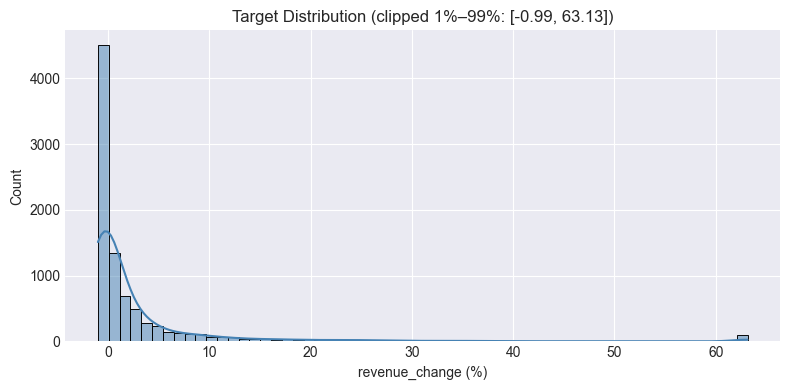

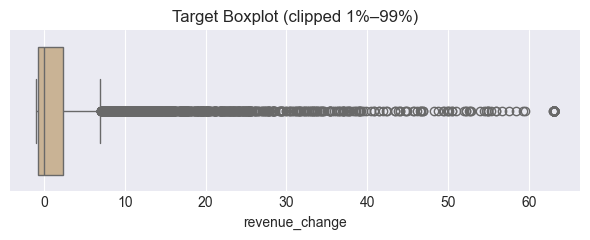

In [27]:
# Target histogram with clipped view (visualization only)
target_series = train_df[target_col].dropna()
lo, hi = clip_bounds(target_series, 0.01, 0.99)

plt.figure(figsize=(8, 4))
sns.histplot(target_series.clip(lo, hi), bins=60, kde=True, color='steelblue')
plt.title(f"Target Distribution (clipped 1%–99%: [{lo:.2f}, {hi:.2f}])")
plt.xlabel(f"{target_col} (%)")
plt.tight_layout()
save_fig('target_hist_clipped')
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=target_series.clip(lo, hi), color='tan')
plt.title('Target Boxplot (clipped 1%–99%)')
plt.tight_layout()
save_fig('target_boxplot_clipped')
plt.show()


**What this shows:** the central mass of the target with heavy tails still present (visual clipping only).
**Why it matters for modeling:** tail risk and heteroskedasticity imply robust losses (MAE/Huber), and possibly log-transforming the target for stability.


### 4. Missingness Overview


Missing Values (non-zero):


,Missing Count,Percentage
revenue_change,2999,25.355090
province,919,7.769699
leverage,45,0.380453
roe,45,0.380453


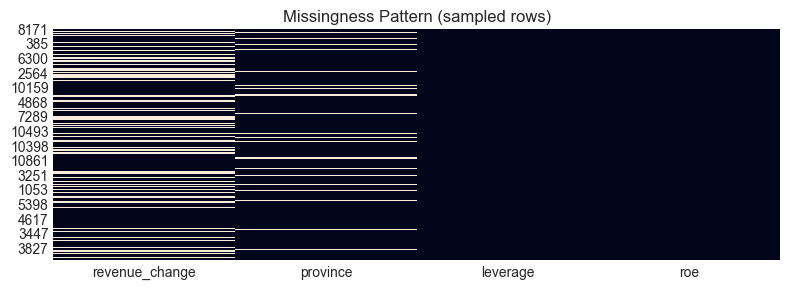

In [28]:
# Missingness table
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values (non-zero):")
display(missing_df[missing_df['Missing Count'] > 0])

# Missingness pattern heatmap (sampled rows)
missing_cols = missing_df[missing_df['Missing Count'] > 0].index.tolist()
if missing_cols:
    sample = train_df[missing_cols].isna().sample(min(300, len(train_df)), random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 3))
    sns.heatmap(sample, cbar=False)
    plt.title('Missingness Pattern (sampled rows)')
    plt.tight_layout()
    save_fig('missingness_pattern')
    plt.show()


**What this shows:** which columns are incomplete and whether missingness is structured.  
**Why it matters for modeling:** supports targeted imputation and optional missingness indicators.


### 5. Outlier Behavior (Top Skewed Monetary Features)


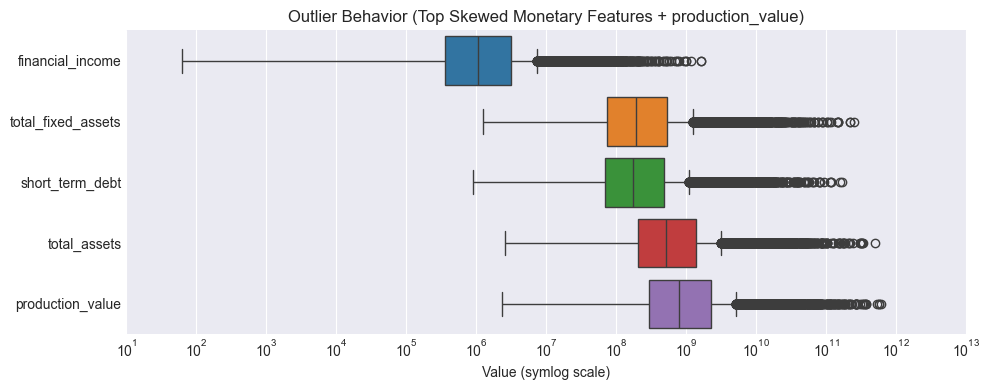

In [29]:
# Outlier behavior via top skewed numeric features (log-scale view for readability)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Heuristic: focus on monetary features (exclude ratios)
monetary_like = [c for c in num_features if any(x in c for x in ['assets', 'debt', 'income', 'value', 'costs', 'profit'])]
if len(monetary_like) >= 4:
    top_outlier_cols = top_skewed_features(train_df, monetary_like, k=4)
else:
    top_outlier_cols = top_skewed_features(train_df, num_features, k=4)

# Always include production_value if present
if 'production_value' in num_features and 'production_value' not in top_outlier_cols:
    top_outlier_cols = top_outlier_cols + ['production_value']

plt.figure(figsize=(10, 4))
sns.boxplot(data=train_df[top_outlier_cols], orient='h')
plt.xscale('symlog', linthresh=1.0)

# Clip x-axis to positive range (no space below 0)
lo, hi = clip_bounds(train_df[top_outlier_cols].stack().dropna(), 0.01, 0.99)
plt.xlim(1e1, 1e13)
plt.title('Outlier Behavior (Top Skewed Monetary Features + production_value)')
plt.xlabel('Value (symlog scale)')
plt.tight_layout()
save_fig('outlier_boxplots_top4_symlog')
plt.show()


**What this shows:** tail behavior in core monetary variables without extreme compression.  
**Why it matters for modeling:** motivates robust scaling or tree models that handle heavy tails.


### 6. Representative Numeric Distributions


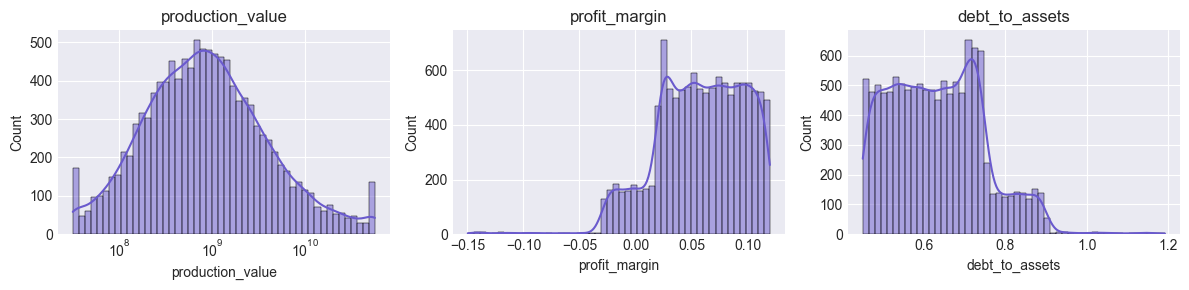

In [30]:
# Representative features: scale (production_value), profitability (profit_margin), leverage (debt_to_assets)
rep_features = [
    c for c in ['production_value', 'profit_margin', 'debt_to_assets']
    if c in train_df.columns
]

fig, axes = plt.subplots(1, len(rep_features), figsize=(4 * len(rep_features), 3))
if len(rep_features) == 1:
    axes = [axes]

for ax, col in zip(axes, rep_features):
    data = train_df[col].dropna()
    if col in ['production_value']:
        data = data.clip(*clip_bounds(data, 0.01, 0.99))
        ax.set_xscale('symlog', linthresh=1.0)
    sns.histplot(data, bins=50, kde=True, ax=ax, color='slateblue')
    ax.set_title(col)

plt.tight_layout()
save_fig('representative_numeric_distributions')
plt.show()


**What this shows:** typical shapes for scale, profitability, and leverage features.  
**Why it matters for modeling:** indicates which variables need scaling or transformation for linear models.


### 7. Multicollinearity Structure


Dropped (scale/total group): ['total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'financial_expenses', 'net_profit_loss']
Kept (scale/total group): ['total_fixed_assets', 'current_assets', 'operating_income', 'financial_income']
Dropped (ratio group): ['quick_ratio']
Kept (ratio group): ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio']


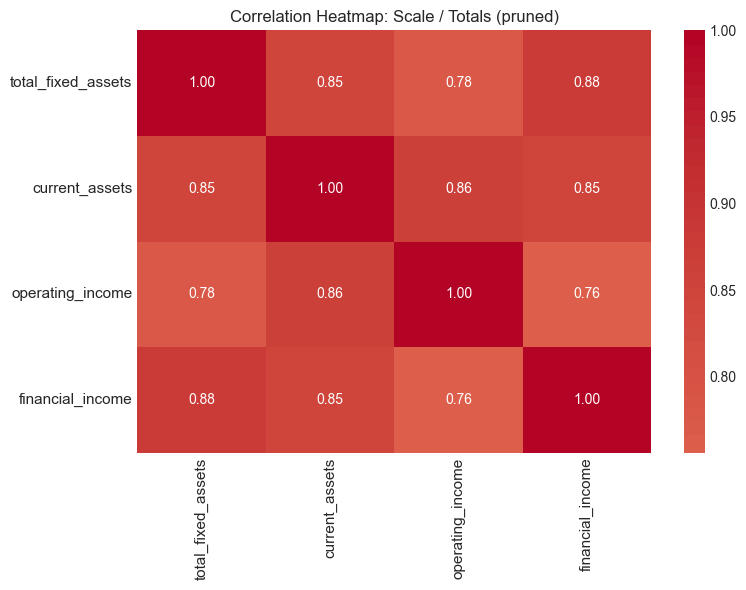

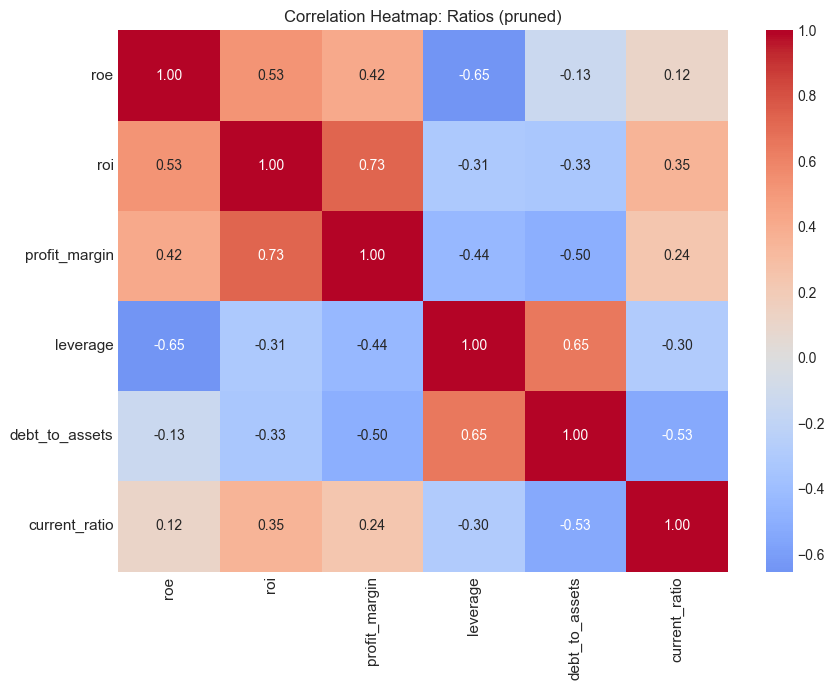

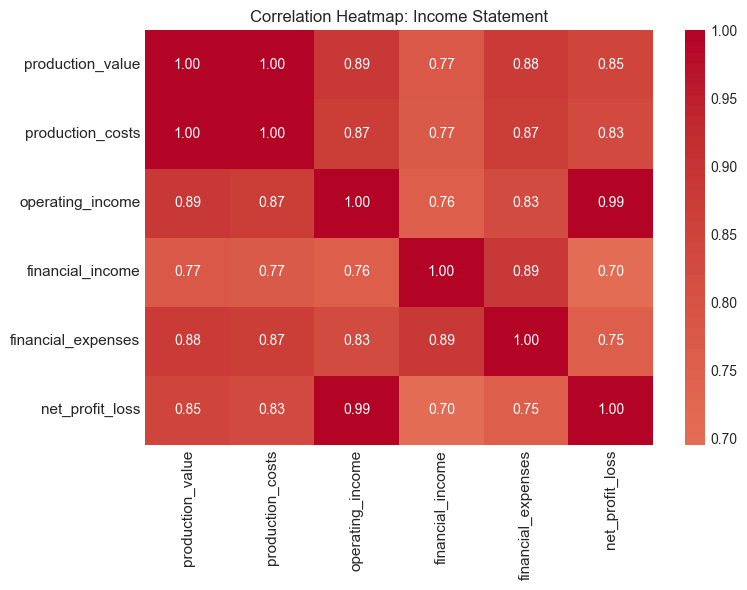

In [31]:
# Correlation heatmaps split into totals vs ratios + drop highly correlated (>|0.90|)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Define ratio vs totals groups (adjust if needed)
ratio_features = [
    c for c in ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio', 'quick_ratio']
    if c in num_features
]

# Income statement group (core statement line items)
income_statement_candidates = [
    'production_value', 'production_costs', 'operating_income',
    'financial_income', 'financial_expenses', 'net_profit_loss'
]
income_statement_features = [c for c in income_statement_candidates if c in num_features]

scale_features = [c for c in num_features if c not in ratio_features]

# Drop years_in_business explicitly from scale heatmap
scale_features = [c for c in scale_features if c != 'years_in_business']

# Drop highly correlated features within each group (greedy, |corr| > 0.90)

def drop_high_corr(df, cols, threshold=0.90):
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    keep_cols = [c for c in cols if c not in drop_cols]
    return keep_cols, drop_cols, corr

scale_keep, scale_drop, scale_corr = drop_high_corr(train_df, scale_features, threshold=0.90)
ratio_keep, ratio_drop, ratio_corr = drop_high_corr(train_df, ratio_features, threshold=0.90)

print("Dropped (scale/total group):", scale_drop)
print("Kept (scale/total group):", scale_keep)
print("Dropped (ratio group):", ratio_drop)
print("Kept (ratio group):", ratio_keep)

# Heatmap A: Scale/Totals
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[scale_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Correlation Heatmap: Scale / Totals (pruned)')
plt.xticks(fontsize=11, rotation=90)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
save_fig('correlation_heatmap_scale_totals')
plt.show()

# Heatmap B: Ratios
if len(ratio_keep) > 0:
    plt.figure(figsize=(9, 7))
    sns.heatmap(train_df[ratio_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Ratios (pruned)')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_ratios')
    plt.show()

# Heatmap C: Income Statement
if len(income_statement_features) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_df[income_statement_features].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Income Statement')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_income_statement')
    plt.show()


**What this shows:** strong linear dependencies among financial totals and ratios.  
**Why it matters for modeling:** suggests regularization (Ridge/ElasticNet) or tree-based models.


### 8. Feature–Target Relationships (Top 2, Interpretable)


Top 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
production_value,0.170943,0.560179
production_costs,0.170918,0.559153
total_assets,0.169760,0.552149
current_assets,0.177701,0.549283
total_debt,0.172818,0.547522
short_term_debt,0.169686,0.544645
long_term_debt,0.170591,0.541098
financial_expenses,0.174653,0.535139
shareholders_equity,0.159066,0.530878
total_fixed_assets,0.147850,0.527454


Bottom 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
financial_income,0.148976,0.458828
net_profit_loss,0.151149,0.432071
roe,0.004309,0.059643
roi,0.010585,0.054971
quick_ratio,-0.008009,-0.012751
current_ratio,-0.008009,-0.012749
years_in_business,0.017032,0.005446
debt_to_assets,-0.002276,-0.000359
profit_margin,0.006333,-0.000234
leverage,-0.005303,-0.000192


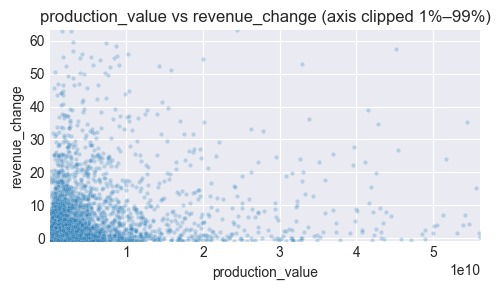

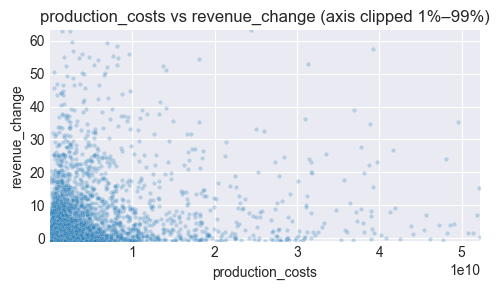

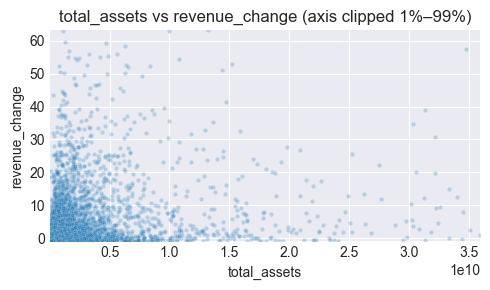

In [32]:
# Correlation of numeric features with target (Pearson and Spearman)
analysis_df = train_df.dropna(subset=[target_col])

numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

pearson_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col])
spearman_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    'pearson': pearson_corr,
    'spearman': spearman_corr
}).sort_values('spearman', key=lambda s: s.abs(), ascending=False)

print("Top 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.head(10))

print("Bottom 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.tail(10))

# Scatter plots for the top 3 features with axis-only clipping (1%–99%)
for col in corr_df.head(3).index:
    x = analysis_df[col].values
    y = analysis_df[target_col].values

    x_clip = clip_bounds(pd.Series(x), 0.01, 0.99)
    y_clip = clip_bounds(pd.Series(y), 0.01, 0.99)

    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=analysis_df, x=col, y=target_col, alpha=0.25, s=10)
    plt.title(f'{col} vs {target_col} (axis clipped 1%–99%)')
    plt.xlim(x_clip)
    plt.ylim(y_clip)
    plt.tight_layout()
    save_fig(f'feature_target_scatter_{col}')
    plt.show()

# Categorical relationships with target (violin plots for top categories) with y-axis clipping
cat_cols = analysis_df.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in cat_features:
        cat_features.append(c)



**What this shows:** density concentrates in narrow bands with non‑linear spread and weak conditional shifts.
**Why it matters for modeling:** simple linear fits will underperform; consider log inputs, interaction terms, or tree/boosted models.


### 9. Categorical Signal (Top-N + Other)


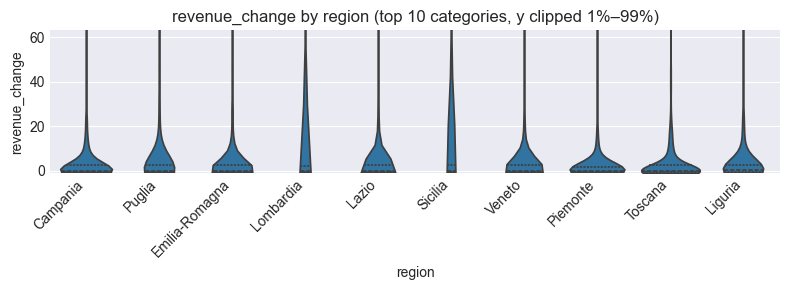

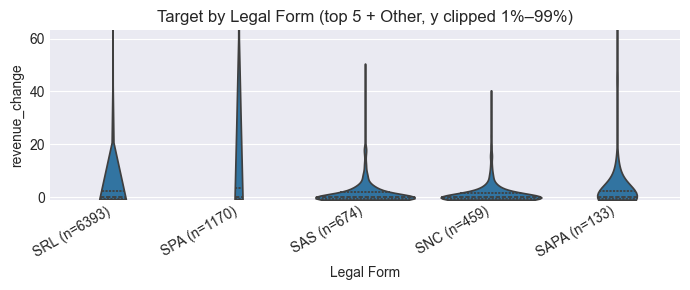

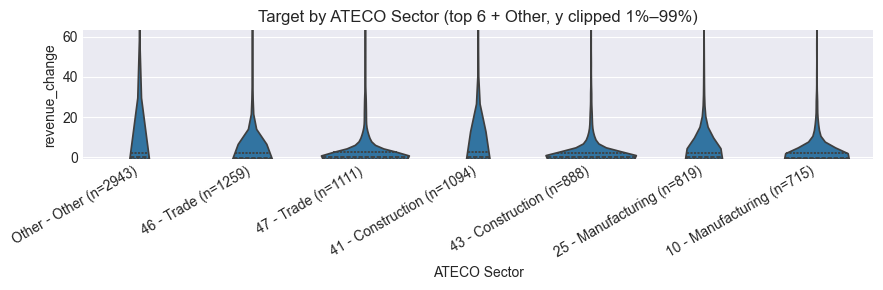

In [33]:
# Compute target clip bounds for consistent y-axis scaling
y_lo, y_hi = clip_bounds(analysis_df[target_col], 0.01, 0.99)

for col in [c for c in [ 'region'] if c in cat_features]:
    top_cats = analysis_df[col].value_counts().head(10).index
    plot_df = analysis_df[analysis_df[col].isin(top_cats)]
    plt.figure(figsize=(8, 3))
    sns.violinplot(data=plot_df, x=col, y=target_col, inner='quartile', cut=0)
    plt.title(f'{target_col} by {col} (top 10 categories, y clipped 1%–99%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig(f'target_by_{col}')
    plt.show()
# Analysis: diagnostics only; do not engineer features here to avoid leakage.

# Target by legal_form (top-N + Other) with y-axis clipping and violin plots
if 'legal_form' in train_df.columns:
    plot_df = train_df[[target_col, 'legal_form']].dropna()
    plot_df['legal_form_grouped'] = top_categories_with_other(plot_df, 'legal_form', top_n=5)

    counts = plot_df['legal_form_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{cat} (n={counts[cat]})" for cat in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(7, 3))
    sns.violinplot(data=plot_df, x='legal_form_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by Legal Form (top 5 + Other, y clipped 1%–99%)')
    plt.xlabel('Legal Form')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_legal_form')
    plt.show()

# Target by ateco_sector (top-N + Other) with y-axis clipping and violin plots
if 'ateco_sector' in train_df.columns:
    plot_df = train_df[[target_col, 'ateco_sector']].dropna()
    plot_df['ateco_sector_grouped'] = top_categories_with_other(plot_df, 'ateco_sector', top_n=6)

    # ATECO 2-digit sector name mapping (compact, for labels)
    def ateco_name(code):
        try:
            c = int(str(code))
        except Exception:
            return 'Other'
        if 1 <= c <= 3:
            return 'Agriculture'
        if 5 <= c <= 9:
            return 'Mining'
        if 10 <= c <= 33:
            return 'Manufacturing'
        if c == 35:
            return 'Utilities'
        if 36 <= c <= 39:
            return 'Water/Waste'
        if 41 <= c <= 43:
            return 'Construction'
        if 45 <= c <= 47:
            return 'Trade'
        if 49 <= c <= 53:
            return 'Transport'
        if 55 <= c <= 56:
            return 'Accommodation/Food'
        if 58 <= c <= 63:
            return 'Info/Comm'
        if 64 <= c <= 66:
            return 'Finance/Insurance'
        if c == 68:
            return 'Real Estate'
        if 69 <= c <= 75:
            return 'Prof/Tech'
        if 77 <= c <= 82:
            return 'Admin/Support'
        if c == 84:
            return 'Public Admin'
        if c == 85:
            return 'Education'
        if 86 <= c <= 88:
            return 'Health/Social'
        if 90 <= c <= 93:
            return 'Arts/Rec'
        if 94 <= c <= 96:
            return 'Other Services'
        return 'Other'

    counts = plot_df['ateco_sector_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{code} - {ateco_name(code)} (n={counts[code]})" for code in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(9, 3))
    sns.violinplot(data=plot_df, x='ateco_sector_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by ATECO Sector (top 6 + Other, y clipped 1%–99%)')
    plt.xlabel('ATECO Sector')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_ateco_sector')
    plt.show()


**What this shows:** category medians differ, but IQR overlap is substantial in several groups.
**Why it matters for modeling:** categories carry signal but require robust encoding; tree models may capture cross‑effects better than linear baselines.


### 10. Leakage Audit (Mandatory)


In [34]:
# Identify suspicious columns that may contain future or post-event info
suspicious_patterns = ['next', 'future', 'after', 't+1', 'post']
flagged_cols = [
    c for c in train_df.columns
    if any(p in c.lower() for p in suspicious_patterns)
]

# Explicit known leakage targets
explicit_leakage = ['bankruptcy_next_year', 'financial_health_class']
flagged = sorted(set(flagged_cols + [c for c in explicit_leakage if c in train_df.columns]))

print("Flagged potential leakage columns:")
print(flagged)

print("\nLeakage prevention steps:")
print("- Exclude flagged columns from feature lists.")
print("- Use temporal splits by fiscal_year to avoid future information.")
print("- Do not engineer features using target values.")
print("- Use transformations only for visualization; no target-conditioned filtering.")


Flagged potential leakage columns:
['bankruptcy_next_year', 'financial_health_class']

Leakage prevention steps:
- Exclude flagged columns from feature lists.
- Use temporal splits by fiscal_year to avoid future information.
- Do not engineer features using target values.
- Use transformations only for visualization; no target-conditioned filtering.


**What this shows:** explicit audit of risky columns and safeguards.  
**Why it matters for modeling:** ensures evaluation integrity and prevents leakage-driven optimism.


### Key EDA Conclusions (Lean Summary)


- Target is heavy‑tailed and skewed; robust losses or transforms are likely necessary.
- Missingness is limited to a few columns, supporting focused imputation.
- Monetary features show extreme outliers; robust scaling or tree models are preferred.
- Strong multicollinearity exists among balance sheet totals; regularization is advisable.
- Legal form and sector show categorical signal worth encoding.
- Leakage risk is controlled by explicit exclusions and temporal splits.


## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [35]:
# Train/Validation/Test split (temporal, leakage-safe)
# IMPORTANT: Split by year BEFORE any fitted preprocessing.

# Create a copy for preprocessing
df_processed = train_df.copy()

# --- Feature engineering (leakage-safe, run BEFORE split) ---
# Uses only PAST data within each company (strictly causal)
def apply_feature_engineering(df):
    df = df.sort_values(['company_id', 'fiscal_year']).copy()

    # Choose core numeric features for YoY deltas/growth
    base_cols = [
        c for c in [
            'production_value', 'production_costs', 'operating_income',
            'total_assets', 'total_debt', 'shareholders_equity',
            'current_assets', 'short_term_debt', 'long_term_debt',
            'net_profit_loss'
        ] if c in df.columns
    ]

    # Year-over-year absolute change (use LAST year's change only)
    for col in base_cols:
        change = df.groupby('company_id')[col].diff()
        df[f'{col}_yoy_change'] = change.groupby(df['company_id']).shift(1)

    # Year-over-year percentage change (use LAST year's change only)
    for col in base_cols:
        prev = df.groupby('company_id')[col].shift(1)
        yoy_pct = (df[col] - prev) / prev.replace(0, np.nan)
        df[f'{col}_yoy_pct'] = yoy_pct.groupby(df['company_id']).shift(1)

    # Lag-1 target (past revenue_change, leakage-safe)
    if 'revenue_change' in df.columns:
        df['revenue_change_lag1'] = (
            df.groupby('company_id')['revenue_change'].shift(1)
        )

    # Temporal features: 2-year rolling mean/volatility (past-only)
    for col in base_cols:
        roll_mean = (
            df.groupby('company_id')[col]
            .rolling(window=2, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        roll_std = (
            df.groupby('company_id')[col]
            .rolling(window=2, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
        df[f'{col}_roll2_mean'] = roll_mean.groupby(df['company_id']).shift(1)
        df[f'{col}_roll2_std'] = roll_std.groupby(df['company_id']).shift(1)

    # Creation of new financial indicators (domain-driven, current-year only)
    # These are assumed available at prediction time for the year being scored.
    def safe_div(num, den):
        den = den.replace(0, np.nan) if hasattr(den, 'replace') else den
        return num / den

    if {'production_value', 'operating_income'} <= set(df.columns):
        df['operating_margin'] = safe_div(df['operating_income'], df['production_value'])

    if {'production_value', 'net_profit_loss'} <= set(df.columns):
        df['net_margin'] = safe_div(df['net_profit_loss'], df['production_value'])

    if {'production_value', 'total_assets'} <= set(df.columns):
        df['asset_turnover'] = safe_div(df['production_value'], df['total_assets'])

    if {'shareholders_equity', 'total_assets'} <= set(df.columns):
        df['equity_ratio'] = safe_div(df['shareholders_equity'], df['total_assets'])

    if {'total_debt', 'shareholders_equity'} <= set(df.columns):
        df['debt_to_equity'] = safe_div(df['total_debt'], df['shareholders_equity'])

    if {'current_assets', 'short_term_debt'} <= set(df.columns):
        df['working_capital'] = df['current_assets'] - df['short_term_debt']

    if {'current_assets', 'short_term_debt', 'total_assets'} <= set(df.columns):
        df['working_capital_ratio'] = safe_div(
            df['current_assets'] - df['short_term_debt'], df['total_assets']
        )

    # Interaction features (scale-aware, no target use)
    if 'total_assets' in df.columns:
        df['log_total_assets'] = np.log1p(df['total_assets'])

    if {'log_total_assets', 'profit_margin'} <= set(df.columns):
        df['size_x_profit'] = df['log_total_assets'] * df['profit_margin']

    if {'leverage', 'profit_margin'} <= set(df.columns):
        df['leverage_x_profit'] = df['leverage'] * df['profit_margin']

    if {'current_ratio', 'leverage'} <= set(df.columns):
        df['liquidity_over_leverage'] = safe_div(df['current_ratio'], 1 + df['leverage'])

    # Sector-relative features (past years only, computed once to avoid duplicate merges)
    if 'ateco_sector' in df.columns and base_cols:
        # drop existing sector features to avoid suffixes on reruns
        drop_cols = [f'{c}_sector_mean' for c in base_cols] + [f'{c}_sector_dev' for c in base_cols]
        drop_cols = [c for c in drop_cols if c in df.columns]
        if drop_cols:
            df = df.drop(columns=drop_cols)

        sector_year_mean = (
            df.groupby(['ateco_sector', 'fiscal_year'])[base_cols]
              .mean()
              .reset_index()
              .sort_values(['ateco_sector', 'fiscal_year'])
        )

        # expanding past mean by sector (shifted)
        for col in base_cols:
            sector_year_mean[f'{col}_sector_mean'] = (
                sector_year_mean.groupby('ateco_sector')[col]
                                .expanding()
                                .mean()
                                .shift(1)
                                .reset_index(level=0, drop=True)
            )

        keep_cols = ['ateco_sector', 'fiscal_year'] + [f'{c}_sector_mean' for c in base_cols]
        sector_year_mean = sector_year_mean[keep_cols]

        df = df.merge(sector_year_mean, on=['ateco_sector', 'fiscal_year'], how='left')

        for col in base_cols:
            df[f'{col}_sector_dev'] = df[col] - df[f'{col}_sector_mean']

    return df

df_processed = apply_feature_engineering(df_processed)

# Challenge 3 (time series):
train_years = [2018, 2019]
val_year = 2020
test_year = 2021

# Temporal split
df = df_processed.copy()

df_train = df[df['fiscal_year'].isin(train_years)].copy()
df_val = df[df['fiscal_year'] == val_year].copy()
df_test = df[df['fiscal_year'] == test_year].copy()


# Training-only cleaning (applied ONLY to 2018-2019)
# Basic cleanup that does not use future information
if 'company_id' in df_train.columns and 'fiscal_year' in df_train.columns:
    before = len(df_train)
    lev_low = df_train['leverage'].quantile(0.02)
    lev_high = df_train['leverage'].quantile(0.98)
    roe_low = df_train['roe'].abs().quantile(0.02)
    roe_high = df_train['roe'].abs().quantile(0.98)
    cr_low = df_train['current_ratio'].quantile(0.02)
    cr_high = df_train['current_ratio'].quantile(0.98)
    qr_low = df_train['quick_ratio'].quantile(0.02)
    qr_high = df_train['quick_ratio'].quantile(0.98)
    rc_low = df_train['revenue_change'].abs().quantile(0.02)
    rc_high = df_train['revenue_change'].abs().quantile(0.98)
    df_train = df_train.drop_duplicates(subset=['company_id', 'fiscal_year'])
    print(f'Dropped duplicate (company_id, fiscal_year) in train: {before - len(df_train)}')

# Remove impossible raw values (train only)
impossible_cols = ['total_assets', 'production_value', 'current_assets', 'total_debt']
if set(impossible_cols).issubset(df_train.columns):
    before = len(df_train)
    df_train = df_train[(df_train['total_assets'] > 0) &
                        (df_train['production_value'] >= 0) &
                        (df_train['current_assets'] >= 0) &
                        (df_train['total_debt'] >= 0)]
    print(f'Removed {before - len(df_train)} train rows with impossible raw values')
else:
    missing_cols = [c for c in impossible_cols if c not in df_train.columns]
    print(f'Skipping impossible-value filter; missing columns: {missing_cols}')

# Financial statement consistency checks (1% tolerance) on train only
consistency_cols = {
    'total_assets', 'total_fixed_assets', 'current_assets',
    'total_debt', 'short_term_debt', 'long_term_debt',
    'shareholders_equity', 'operating_income', 'production_value',
    'production_costs', 'roe', 'net_profit_loss', 'roi',
    'profit_margin', 'leverage', 'debt_to_assets',
    'current_ratio', 'quick_ratio'
}
missing_consistency_cols = consistency_cols - set(df_train.columns)
if not missing_consistency_cols:
    import numpy as np

    EPS = 0.01  # 1% tolerance

    def not_close(a, b, eps=EPS):
        return ~np.isclose(a, b, rtol=eps, atol=eps, equal_nan=True)

    with np.errstate(divide='ignore', invalid='ignore'):
        mask = (
            # Balance sheet
            not_close(df_train['total_assets'],
                      df_train['total_fixed_assets'] + df_train['current_assets']) |
            not_close(df_train['total_debt'],
                      df_train['short_term_debt'] + df_train['long_term_debt']) |
            not_close(df_train['shareholders_equity'],
                      df_train['total_assets'] - df_train['total_debt']) |

            # Income statement
            not_close(df_train['operating_income'],
                      df_train['production_value'] - df_train['production_costs']) |

            # Ratios
            not_close(df_train['roe'],
                      df_train['net_profit_loss'] / df_train['shareholders_equity']) |
            not_close(df_train['roi'],
                      df_train['operating_income'] / df_train['total_assets']) |
            not_close(df_train['profit_margin'],
                      df_train['net_profit_loss'] / df_train['production_value']) |
            not_close(df_train['leverage'],
                      df_train['total_debt'] / df_train['shareholders_equity']) |
            not_close(df_train['debt_to_assets'],
                      df_train['total_debt'] / df_train['total_assets']) |
            not_close(df_train['current_ratio'],
                      df_train['current_assets'] / df_train['short_term_debt']) )

    before = len(df_train)
    lev_low = df_train['leverage'].quantile(0.02)
    lev_high = df_train['leverage'].quantile(0.98)
    roe_low = df_train['roe'].abs().quantile(0.02)
    roe_high = df_train['roe'].abs().quantile(0.98)
    cr_low = df_train['current_ratio'].quantile(0.02)
    cr_high = df_train['current_ratio'].quantile(0.98)
    qr_low = df_train['quick_ratio'].quantile(0.02)
    qr_high = df_train['quick_ratio'].quantile(0.98)
    rc_low = df_train['revenue_change'].abs().quantile(0.02)
    rc_high = df_train['revenue_change'].abs().quantile(0.98)
    df_train = df_train.loc[~mask].reset_index(drop=True)
    print(f'Removed {mask.sum()} inconsistent rows from train')
    print(f'Remaining train rows: {len(df_train)} (dropped {before - len(df_train)})')
else:
    print(f'Skipping consistency checks on train; missing columns: {sorted(missing_consistency_cols)}')

# Ratio sanity bounds (2nd–98th percentile + fixed caps) on train only
ratio_bound_cols = {
    'leverage', 'debt_to_assets', 'roe', 'roi',
    'profit_margin', 'current_ratio', 'quick_ratio',
    'revenue_change'
}
missing_ratio_bound_cols = ratio_bound_cols - set(df_train.columns)
if not missing_ratio_bound_cols:
    before = len(df_train)
    lev_low = df_train['leverage'].quantile(0.02)
    lev_high = df_train['leverage'].quantile(0.98)
    roe_low = df_train['roe'].abs().quantile(0.02)
    roe_high = df_train['roe'].abs().quantile(0.98)
    cr_low = df_train['current_ratio'].quantile(0.02)
    cr_high = df_train['current_ratio'].quantile(0.98)
    qr_low = df_train['quick_ratio'].quantile(0.02)
    qr_high = df_train['quick_ratio'].quantile(0.98)
    rc_low = df_train['revenue_change'].abs().quantile(0.02)
    rc_high = df_train['revenue_change'].abs().quantile(0.98)

    df_train = df_train[
        (df_train['leverage'] >= lev_low) & (df_train['leverage'] <= lev_high) &
        (df_train['debt_to_assets'] <= 3) &
        (df_train['roe'].abs() >= roe_low) & (df_train['roe'].abs() <= roe_high) &
        (df_train['roi'].abs() <= 2) &
        (df_train['profit_margin'].between(-2, 1)) &
        (df_train['current_ratio'] >= cr_low) & (df_train['current_ratio'] <= cr_high) &
        (df_train['quick_ratio'] >= qr_low) & (df_train['quick_ratio'] <= qr_high) &
        (df_train['revenue_change'].abs() >= rc_low) & (df_train['revenue_change'].abs() <= rc_high)
    ]
    print(f'Removed {before - len(df_train)} train rows outside ratio bounds')
else:
    print(f'Skipping ratio bounds on train; missing columns: {sorted(missing_ratio_bound_cols)}')

# Drop rows with missing target AFTER split (avoids leakage)
df_train = df_train.dropna(subset=[target_col])
df_val = df_val.dropna(subset=[target_col])
df_test = df_test.dropna(subset=[target_col])

print('Train/validation/test split complete!')
print(f'Train years: {train_years}, rows: {df_train.shape[0]}')
print(f'Val year: {val_year}, rows: {df_val.shape[0]}')
print(f'Test year: {test_year}, rows: {df_test.shape[0]}')


Dropped duplicate (company_id, fiscal_year) in train: 0
Removed 0 train rows with impossible raw values
Removed 23 inconsistent rows from train
Remaining train rows: 5917 (dropped 23)
Removed 3425 train rows outside ratio bounds
Train/validation/test split complete!
Train years: [2018, 2019], rows: 2492
Val year: 2020, rows: 2956
Test year: 2021, rows: 2932


In [36]:
# Preprocessing (leakage-safe): fit on train only, apply to val/test

# Define columns to exclude from features
leakage_cols = ['company_id', 'bankruptcy_next_year', 'financial_health_class', target_col]

# Identify categorical features (treat ateco_sector as categorical)
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
if 'ateco_sector' in df_train.columns and 'ateco_sector' not in cat_cols:
    cat_cols.append('ateco_sector')

cat_cols = [c for c in cat_cols if c not in leakage_cols]
# Add fiscal_year as categorical for year fixed effects
if 'fiscal_year' in df_train.columns and 'fiscal_year' not in cat_cols:
    cat_cols.append('fiscal_year')

# Numeric feature columns
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in leakage_cols]

# Replace inf with NaN in numeric columns
for d in [df_train, df_val, df_test]:
    d[num_cols] = d[num_cols].replace([np.inf, -np.inf], np.nan)

# Cast categorical columns to string to allow 'Unknown'/'Other'
for d in [df_train, df_val, df_test]:
    for c in cat_cols:
        d[c] = d[c].astype('string')

# Missing indicator features (based on train missingness)
missing_indicator_cols = [c for c in (num_cols + cat_cols) if df_train[c].isna().mean() > 0]
for c in missing_indicator_cols:
    df_train[f'{c}_missing'] = df_train[c].isna().astype(int)
    df_val[f'{c}_missing'] = df_val[c].isna().astype(int)
    df_test[f'{c}_missing'] = df_test[c].isna().astype(int)

# Missing value handling
# 1) Numeric: median imputation using TRAIN stats (optionally by sector)
use_group_median = 'ateco_sector' in df_train.columns

if use_group_median:
    # compute train medians by sector + global fallback
    global_median = df_train[num_cols].median(numeric_only=True)
    sector_median = df_train.groupby('ateco_sector')[num_cols].median(numeric_only=True)

    def impute_numeric(df):
        # fill by sector medians, then global
        if 'ateco_sector' in df.columns:
            df[num_cols] = df[num_cols].fillna(sector_median)
        df[num_cols] = df[num_cols].fillna(global_median)
        return df
else:
    global_median = df_train[num_cols].median(numeric_only=True)

    def impute_numeric(df):
        df[num_cols] = df[num_cols].fillna(global_median)
        return df

# 2) Categorical: fill missing as "Unknown" (train-defined categories)

def impute_categorical(df):
    if len(cat_cols) == 0:
        return df
    df[cat_cols] = df[cat_cols].fillna('Unknown')
    return df

# Apply imputations
for d in [df_train, df_val, df_test]:
    d = impute_numeric(d)
    d = impute_categorical(d)

# Handle unseen categories in val/test -> map to "Other"
cat_levels = {c: set(df_train[c].dropna().unique()) for c in cat_cols}
for c in cat_cols:
    for d in [df_val, df_test]:
        d.loc[~d[c].isin(cat_levels[c]), c] = 'Other'

# Winsorize ratio features (1st–99th) using TRAIN bounds only
ratio_cols = [c for c in ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio', 'quick_ratio'] if c in num_cols]
if ratio_cols:
    ratio_bounds = {c: df_train[c].quantile([0.01, 0.99]).values for c in ratio_cols}
    for d in [df_train, df_val, df_test]:
        for c in ratio_cols:
            lo, hi = ratio_bounds[c]
            d[c] = d[c].clip(lo, hi)

# Log-transform skewed scale variables (create new features)
log_cols = [c for c in ['production_value', 'total_assets', 'total_debt', 'current_assets'] if c in num_cols]
for d in [df_train, df_val, df_test]:
    for c in log_cols:
        d[f'log1p_{c}'] = np.log1p(d[c].clip(lower=0))

# One-hot encode categoricals (fit on train; align columns for val/test)
X_train = df_train.drop(columns=leakage_cols)
X_val = df_val.drop(columns=leakage_cols)
X_test = df_test.drop(columns=leakage_cols)

y_train = df_train[target_col]
y_val = df_val[target_col]
y_test = df_test[target_col]

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)

# Align columns to train set
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Final NaN cleanup (train-only statistics)
nan_cols = X_train.columns[X_train.isna().any()].tolist()
if nan_cols:
    train_medians = X_train[nan_cols].median(numeric_only=True)
    X_train[nan_cols] = X_train[nan_cols].fillna(train_medians)
    X_val[nan_cols] = X_val[nan_cols].fillna(train_medians)
    X_test[nan_cols] = X_test[nan_cols].fillna(train_medians)
    # fallback for any remaining NaNs (e.g., all-NaN columns)
    X_train[nan_cols] = X_train[nan_cols].fillna(0)
    X_val[nan_cols] = X_val[nan_cols].fillna(0)
    X_test[nan_cols] = X_test[nan_cols].fillna(0)

print("Preprocessing complete!")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# Feature scaling
# IMPORTANT: Fit scaler on training data only!

from sklearn.preprocessing import StandardScaler, RobustScaler

# Choose scaler (RobustScaler is safer with outliers)
scaler = RobustScaler()

# Scale numeric columns only (dummy variables remain 0/1)
num_feature_cols = [c for c in X_train.columns if c in num_cols]

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_feature_cols] = scaler.fit_transform(X_train[num_feature_cols])
X_val_scaled[num_feature_cols] = scaler.transform(X_val[num_feature_cols])
X_test_scaled[num_feature_cols] = scaler.transform(X_test[num_feature_cols])

print("Feature scaling complete!")
print(f"Scaled shapes: {X_train_scaled.shape}, {X_val_scaled.shape}, {X_test_scaled.shape}")


Preprocessing complete!
X_train: (2492, 181), X_val: (2956, 181), X_test: (2932, 181)
Feature scaling complete!
Scaled shapes: (2492, 181), (2956, 181), (2932, 181)


**Engineered Features:**

1. **YoY absolute changes** for key financials (e.g., `production_value_yoy_change`, `total_assets_yoy_change`). Captures momentum without using future data.
2. **YoY percentage changes** for the same set (e.g., `production_value_yoy_pct`). Normalizes growth across firm size.
3. **Lag-1 target** (`revenue_change_lag1`) uses prior-year change only.
4. **Rolling 2-year mean & volatility** per company (e.g., `operating_income_roll2_mean`, `operating_income_roll2_std`). Captures short-term trend and stability.
5. **New financial indicators** (domain-driven, current-year only):
   - `operating_margin`, `net_margin`, `asset_turnover`
   - `equity_ratio`, `debt_to_equity`
   - `working_capital`, `working_capital_ratio`
6. **Interaction features** (scale-aware, non-leaky):
   - `size_x_profit` (log size × profitability)
   - `leverage_x_profit`, `liquidity_over_leverage`
7. **Sector-relative deviations** by year (e.g., `total_assets_sector_dev`). Measures how a firm differs from its sector peers in the same fiscal year.

**Financial ratios (already in data):** `roe`, `roi`, `profit_margin`, `leverage`, `debt_to_assets`, `current_ratio`, `quick_ratio`. These are kept as interpretable features (profitability, leverage, liquidity) and are discussed in multicollinearity analysis.

**Feature selection methodology (non-leaky):**
- Remove exact/near-duplicate features and low-variance columns.
- Drop one of any highly correlated pairs (|ρ| > 0.90) using domain preference (retain more interpretable ratios).
- Avoid any target-informed filtering; all pruning is feature-only.


## 5. Model Development

Train multiple models and compare performance.

In [37]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [38]:
# Prepare X and y (use processed matrices)

# Feature columns are all columns after preprocessing (excluding target/leakage already handled)
feature_cols = X_train.columns.tolist()

X_train = X_train.copy()
y_train = y_train.copy()
X_val = X_val.copy()
y_val = y_val.copy()
X_test = X_test.copy()
y_test = y_test.copy()

print("Data prepared for modeling!")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Data prepared for modeling!
X_train: (2492, 181), y_train: (2492,)
X_val: (2956, 181), y_val: (2956,)
X_test: (2932, 181), y_test: (2932,)


### Baseline Model

In [39]:
# TODO: Train baseline model
# For regression: Linear Regression


baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_val_scaled)

print("Baseline Model Performance:")
print(f"R^2 Score: {r2_score(y_val, y_pred_baseline):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_val, y_pred_baseline):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_val, y_pred_baseline):.4f}")

Baseline Model Performance:
R^2 Score: -390837374880605571706632719422193664.0000
Mean Absolute Error: 6118693410101240832.0000
Mean Squared Error: 741892815181847330841670205717788753920.0000


### Advanced Models

In [40]:
# Target transform helpers (robust to heavy tails)

def y_transform(y):
    # signed log1p transform
    return np.sign(y) * np.log1p(np.abs(y))


def y_inverse(y_t):
    return np.sign(y_t) * (np.expm1(np.abs(y_t)))


In [41]:
# Advanced Models (Regression) with target transform and robust metrics
# - Baselines: median, lag1, sector mean
# - Random Forest
# - Gradient Boosting
# - XGBoost (if available)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Transform target for training
Y_tr_t = y_transform(y_train)
Y_va_t = y_transform(y_val)

# Metrics helper

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred)) * 100


def eval_regression(name, model, X_tr, y_tr_t, X_va, y_va):
    model.fit(X_tr, y_tr_t)
    preds_t = model.predict(X_va)
    preds = y_inverse(preds_t)
    rmse = mean_squared_error(y_va, preds, squared=False)
    mae = mean_absolute_error(y_va, preds)
    mape = (abs((y_va - preds) / y_va)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    r2 = r2_score(y_va, preds)
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'SMAPE': smape(y_va, preds),
        'R2': r2,
        'DirectionalAcc(%)': directional_accuracy(y_va, preds)
    }

results = []

# Baseline 1: predict train median
baseline_pred = np.full_like(y_val, y_train.median(), dtype=float)
results.append({
    'Model': 'Baseline (median)',
    'RMSE': mean_squared_error(y_val, baseline_pred, squared=False),
    'MAE': mean_absolute_error(y_val, baseline_pred),
    'MAPE': (abs((y_val - baseline_pred) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
    'SMAPE': smape(y_val, baseline_pred),
    'R2': r2_score(y_val, baseline_pred),
    'DirectionalAcc(%)': directional_accuracy(y_val, baseline_pred)
})

# Baseline 2: lag-1 revenue_change from full history (company-level)
if 'revenue_change' in df_processed.columns:
    lag_source = df_processed.sort_values(['company_id', 'fiscal_year']).copy()
    lag_source['rev_change_lag1'] = lag_source.groupby('company_id')['revenue_change'].shift(1)
    # map lag1 to val by company_id + fiscal_year
    lag_map = lag_source.set_index(['company_id', 'fiscal_year'])['rev_change_lag1']
    lag1 = df_val.set_index(['company_id', 'fiscal_year']).index.map(lag_map)
    lag1 = pd.Series(lag1, index=df_val.index).fillna(y_train.median())
    results.append({
        'Model': 'Baseline (lag1 change)',
        'RMSE': mean_squared_error(y_val, lag1, squared=False),
        'MAE': mean_absolute_error(y_val, lag1),
        'MAPE': (abs((y_val - lag1) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
        'SMAPE': smape(y_val, lag1),
        'R2': r2_score(y_val, lag1),
        'DirectionalAcc(%)': directional_accuracy(y_val, lag1)
    })

# Baseline 3: sector mean change (train years only, no year key)
if 'ateco_sector' in df_train.columns:
    sector_mean = df_train.groupby('ateco_sector')['revenue_change'].mean()
    pred = df_val['ateco_sector'].map(sector_mean).fillna(y_train.median())
    results.append({
        'Model': 'Baseline (sector mean)',
        'RMSE': mean_squared_error(y_val, pred, squared=False),
        'MAE': mean_absolute_error(y_val, pred),
        'MAPE': (abs((y_val - pred) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
        'SMAPE': smape(y_val, pred),
        'R2': r2_score(y_val, pred),
        'DirectionalAcc(%)': directional_accuracy(y_val, pred)
    })

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
results.append(eval_regression('RandomForest', rf_model, X_tr, Y_tr_t, X_va, y_val))

# Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)
results.append(eval_regression('GradientBoosting', gbr_model, X_tr, Y_tr_t, X_va, y_val))

# XGBoost (if available)
try:
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    results.append(eval_regression('XGBoost', xgb_model, X_tr, Y_tr_t, X_va, y_val))
except Exception as e:
    print(f'XGBoost not available or failed to import: {e}')

results_df = pd.DataFrame(results)
# Headline metrics: SMAPE + Directional Acc
results_df = results_df.sort_values(['SMAPE', 'DirectionalAcc(%)'])
print('Advanced models evaluated on validation set (original scale):')
display(results_df)


Advanced models evaluated on validation set (original scale):


,Model,RMSE,MAE,MAPE,SMAPE,R2,DirectionalAcc(%)
5,XGBoost,42.550781,4.090755,303.672599,78.745010,0.046172,84.133965
3,RandomForest,42.745378,4.176679,286.355181,80.546458,0.037428,83.626522
4,GradientBoosting,42.468130,4.068403,245.360011,80.754691,0.049874,83.592693
2,Baseline (sector mean),43.661292,5.975857,1536.693473,150.260731,-0.004264,50.135318
0,Baseline (median),43.833795,5.378860,130.172404,175.590717,-0.012216,49.864682
1,Baseline (lag1 change),43.833795,5.378860,130.172404,175.590717,-0.012216,49.864682


In [42]:
# Hyperparameter tuning (focused, leakage-safe) with target transform
# Tune only on TRAIN data using time-aware CV; evaluate on VAL after tuning.

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Transform target
Y_tr_t = y_transform(y_train)
Y_va_t = y_transform(y_val)

# Time-aware CV within training years
cv = TimeSeriesSplit(n_splits=3)

# Random Forest tuning
rf_param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_search.fit(X_tr, Y_tr_t)
rf_best = rf_search.best_estimator_

# Gradient Boosting tuning
gb_param_dist = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.85, 1.0]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_param_dist,
    n_iter=12,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

gb_search.fit(X_tr, Y_tr_t)
gb_best = gb_search.best_estimator_

# Optional: XGBoost tuning (if available)
try:
    from xgboost import XGBRegressor
    xgb_param_dist = {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.85, 1.0]
    }
    xgb_search = RandomizedSearchCV(
        XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        xgb_param_dist,
        n_iter=12,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_search.fit(X_tr, Y_tr_t)
    xgb_best = xgb_search.best_estimator_
except Exception as e:
    xgb_best = None
    print(f"XGBoost tuning skipped: {e}")

# Metrics helper

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred)) * 100


def eval_metrics(model, X, y):
    preds_t = model.predict(X)
    preds = y_inverse(preds_t)
    rmse = mean_squared_error(y, preds, squared=False)
    mae = mean_absolute_error(y, preds)
    mape = (abs((y - preds) / y)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    r2 = r2_score(y, preds)
    return rmse, mae, mape, r2, smape(y, preds), directional_accuracy(y, preds)

results = []
rmse, mae, mape, r2, sm, da = eval_metrics(rf_best, X_va, y_val)
results.append({'Model': 'RandomForest (tuned)', 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da})

rmse, mae, mape, r2, sm, da = eval_metrics(gb_best, X_va, y_val)
results.append({'Model': 'GradientBoosting (tuned)', 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da})

if xgb_best is not None:
    rmse, mae, mape, r2, sm, da = eval_metrics(xgb_best, X_va, y_val)
    results.append({'Model': 'XGBoost (tuned)', 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da})

results_df = pd.DataFrame(results).sort_values('RMSE')
print("Tuned models evaluated on validation set (original scale):")
display(results_df)

print("Hyperparameter tuning complete!")


KeyboardInterrupt: 

## 6. Model Evaluation

Compare models and select the best one.

In [ ]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [ ]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [ ]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [ ]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [ ]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀